# Plant Disease Detection: Potato, Tomato, Corn
This notebook uses data from the PlantVillage dataset and applies Transfer Learning using MobileNetV2 to improve model accuracy for classifying diseases in **potato**, **tomato**, and **corn**.

In [1]:
# 📦 Install Required Libraries
!pip install tensorflow matplotlib numpy scikit-learn

  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.72.0rc1 requires protobuf<7.0dev,>=6.30.0, but you have protobuf 4.25.6 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 📁 Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# 📂 Set Up Directory (Assuming the directory contains only potato, tomato, and corn folders)
dataset_dir = 'D:\Degree\Plant Disease Detection\Plant-Disease-Detection\Dataset\color'  
# e.g., contains subfolders: 'Potato___Late_blight', etc.

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Prerana Walvekar\AppData\Local\Temp\ipykernel_20012\2562596384.py:2: SyntaxWarning: invalid escape sequence '\D'
  dataset_dir = 'D:\Degree\Plant Disease Detection\Plant-Disease-Detection\Dataset\color'


In [4]:
# 🔄 Image Preprocessing and Augmentation
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 10108 images belonging to 11 classes.
Found 2523 images belonging to 11 classes.


In [5]:
# 🔧 Build Transfer Learning Model with MobileNetV2
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# 🏋️‍♂️ Train the Model
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


c:\Users\Prerana Walvekar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


316/316 ━━━━━━━━━━━━━━━━━━━━ 767s 2s/step - accuracy: 0.6431 - loss: 1.0452 - val_accuracy: 0.8962 - val_loss: 0.3046 - learning_rate: 0.0010
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.8882 - loss: 0.3157 - val_accuracy: 0.9247 - val_loss: 0.2249 - learning_rate: 0.0010
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 434s 1s/step - accuracy: 0.9071 - loss: 0.2553 - val_accuracy: 0.9263 - val_loss: 0.1984 - learning_rate: 0.0010
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.9182 - loss: 0.2314 - val_accuracy: 0.9306 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.9228 - loss: 0.2145 - val_accuracy: 0.9310 - val_loss: 0.1900 - learning_rate: 0.0010
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.9296 - loss: 0.2003 - val_accuracy: 0.9402 - val_loss: 0.1730 - learning_rate: 0.0010
Epoch 7/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.9264 - loss: 0.2026 - val_

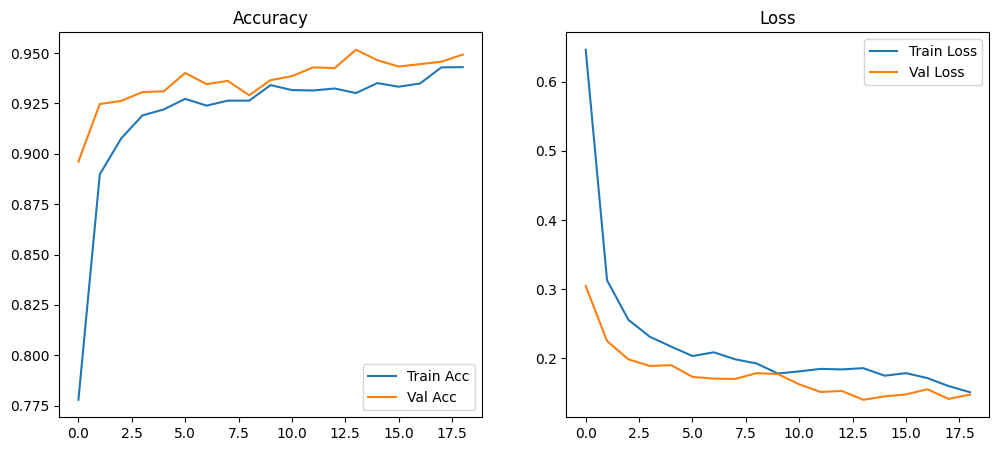

In [7]:
# 📈 Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [8]:
# ✅ Evaluate Model
val_preds = model.predict(val_data)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

79/79 ━━━━━━━━━━━━━━━━━━━━ 68s 849ms/step
                                                    precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.03      0.03      0.03       102
                       Corn_(maize)___Common_rust_       0.10      0.10      0.10       238
               Corn_(maize)___Northern_Leaf_Blight       0.09      0.10      0.09       197
                            Corn_(maize)___healthy       0.09      0.09      0.09       232
                             Potato___Early_blight       0.09      0.09      0.09       200
                              Potato___Late_blight       0.06      0.06      0.06       200
                                  Potato___healthy       0.00      0.00      0.00        30
                           Tomato___Bacterial_spot       0.18      0.19      0.19       425
                             Tomato___Early_blight       0.09      0.08      0.08       200
                              Tomato_

In [9]:
# 💾 Save the trained model
model.save('mobilenetv2_plant_model.h5')
print("✅ Model saved as mobilenetv2_plant_model.h5")


✅ Model saved as mobilenetv2_plant_model.h5
